In [1]:
import matplotlib
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, yt
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *
from PreFRBLE.plot import *
from time import time


In [16]:
FRBs = GetFRBcat()
set = FRBs[ np.where( FRBs['tele'] == telescopes_FRBcat['CHIME'] ) ]
FRBs

array([(b'FRB190523',  760.8  ,  37.  , b'null', b'1.4', b'0.66', b'DSA-10'),
       (b'FRB190222',  460.6  ,  87.  , b'null', b'null', b'null', b'CHIME/FRB'),
       (b'FRB190209',  424.6  ,  46.  , b'null', b'null', b'null', b'CHIME/FRB'),
       (b'FRB190116',  444.   ,  20.  , b'null', b'null', b'null', b'CHIME/FRB'),
       (b'FRB181228',  354.2  ,  58.  , b'null', b'0.2', b'null', b'UTMOST'),
       (b'FRB181128',  450.2  , 112.  , b'null', b'null', b'null', b'CHIME/FRB'),
       (b'FRB181119',  364.2  ,  34.  , b'null', b'null', b'null', b'CHIME/FRB'),
       (b'FRB181112',  589.27 , 102.  , b'10.9', b'null', b'0.47', b'ASKAP'),
       (b'FRB181030',  103.5  ,  40.  , b'null', b'null', b'null', b'CHIME/FRB'),
       (b'FRB181017', 1281.9  ,  43.  , b'null', b'null', b'null', b'CHIME/FRB'),
       (b'FRB181017',  239.97 ,  38.  , b'null', b'0.158', b'null', b'UTMOST'),
       (b'FRB181016', 1982.8  ,  90.  , b'null', b'5.7', b'null', b'UTMOST'),
       (b'FRB180924',  361.42 ,  4

In [24]:
with h5.File( likelihood_file_Full, 'r') as f:
    print( f['primordial/Rodrigues18/Rodrigues18/smd/Piro18/wind'].keys() )

<KeysViewHDF5 ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2.0', '2.1', '2.2']>


tabulate results of Deff for faster performance in fit (doesn't work yet and isn't really needed)

Text(0,0.5,'$D_{eff} = D_L D_{LS} / D_S$ / Gpc')

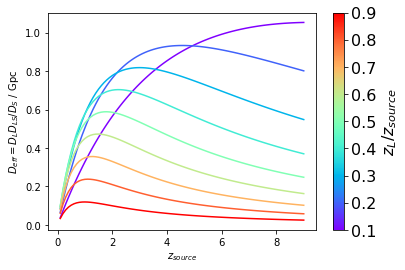

In [10]:
z_s = np.arange(0.1,9.1,0.1)
es = np.arange(0.1,1.,0.1)
for e, color in zip(es, rainbow(np.linspace(0,1,es.size))):
    z_L = e*z_s
    d = Deff( z_L=z_L, z_s=z_s )
    plt.plot(z_s,d, label=r"$\epsilon$ = %.1f " % e, color=color )
Colorbar(es, label=r"$z_L/z_{source}$")
plt.xlabel(r"$z_{source}$")
plt.ylabel(r"$D_{eff} = D_L D_{LS} / D_S$ / Gpc")

the following plot shows the lense position for which $D_{eff}$ is maximized.

Text(0,0.5,'$D_{eff} = D_L D_{LS} / D_S$ / Gpc')

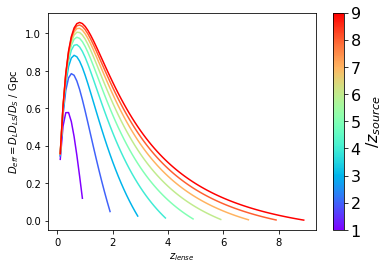

In [3]:
zs = np.arange(1.,10.,1)
for z_s, color in zip(zs, rainbow(np.linspace(0,1,zs.size))):
    z_L = np.arange(0.1,z_s,0.1)
    d = Deff( z_L=z_L, z_s=z_s )
    plt.plot(z_L,d, color=color )
Colorbar(zs, label=r"$z_{source}$")
plt.xlabel(r"$z_{lense}$")
plt.ylabel(r"$D_{eff} = D_L D_{LS} / D_S$ / Gpc")

Text(0,0.5,u'$D_{\\rm eff} = D_L D_{LS} / D_S$')

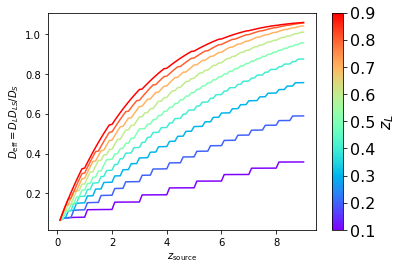

In [281]:
z_s = np.arange(0.1,9.1,0.1)
es = np.arange(0.1,1.0,0.1)
for e, color in zip(es, rainbow(np.linspace(0,1,es.size))):
    z_L = e*z_s
    d = Deff_( z_L=z_L, z_s=z_s )
    plt.plot(z_s,d, label=r"$\epsilon$ = %.1f " % e, color=color )
Colorbar(es, label=r"$z_L$")
plt.xlabel(r"$z_{\rm source}$")
plt.ylabel(r"$D_{\rm eff} = D_L D_{LS} / D_S$ / Gpc")

In [291]:


zs = np.arange(0.1,7.1,0.1)
zL = np.arange(0.0,7.1,0.1)

'''  we table Deff for faster use with IGM and intervening galaxies
deff = np.zeros([z_s.size,z_L.size])
for i_s, zs in enumerate(z_s):
    deff[i_s] = Deff( zs, z_L )

np.save( 'Deff.npy', deff)
#deff = np.load( 'Deff.npy' )
#'''

deff = np.load( 'Deff.npy' )
def Deff_( z_s=np.array(1.0), z_L=np.array(0.5) ):
    i_s = np.searchsorted( zs, z_s )
    i_L = np.searchsorted( zL, z_L )
    return deff[i_s,i_L]

    


### IGM
Here, we translate the likelihood of SM in the IGM, $P(SM_{IGM}|z_s)$, to likelihood of scattering time in the IGM, $P(\tau(SM_{IGM},z_s)|z_s)$.

In [4]:
from scipy.optimize import fmin_slsqp as  fmin

def Deff_max( z_s, accuracy=1e-5 ):
    ### returns optimal redshift and Deff for lense between observer and source at redshift z_s
    Deff_min = lambda z_L : -Deff( z_s=z_s, z_L=z_L )
    ### find z_L that maximizes D_eff(z_s,z_L) for given z_s
    z_L, = fmin( Deff_min, z_s/2, iprint=0, acc=accuracy)
    return z_L, Deff( z_s=z_s, z_L=z_L )
for acc in 10.**np.arange(0,-10,-1):
    t0 = time()
    print( Deff_max( 2.6, accuracy=acc ), "in %.3f s" % ( time()-t0 ) )

(1.3, array([0.55933862])) in 0.077 s
(0.6739167739690881, array([0.84110783])) in 0.144 s
(0.5389864724255012, array([0.84902001])) in 0.205 s
(0.5847061580781668, array([0.85083863])) in 0.283 s
(0.5783046601707997, array([0.85089374])) in 0.312 s
(0.5783046601707997, array([0.85089374])) in 0.335 s
(0.5783046601707997, array([0.85089374])) in 0.345 s
(0.5778384016351521, array([0.85089399])) in 0.377 s
(0.5778384016351521, array([0.85089399])) in 0.407 s
(0.5778384016351521, array([0.85089399])) in 0.385 s


/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/yt/utilities/cosmology.py:623: RuntimeWarning: invalid value encountered in log10
  zbins = np.logspace(np.log10(a + 1), np.log10(b + 1), bins) - 1


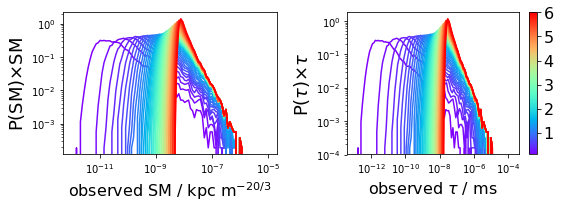

In [6]:
model = 'primordial'  ## other IGM models only differ in RM
fig, axs = plt.subplots( 1, 2, figsize=(8,3))
## for each redshift
for z_s, color in zip(redshift_bins, rainbow( np.linspace(0,1,len(redshift_bins)))):
    ### read likelihood of SM: P(SM_IGM|z_s)
    P, SM = GetLikelihood_IGM( redshift=z_s, model=model, nside=4, measure='SM', absolute=False)
    PlotLikelihood( SM, P, measure='SM', color=color, ax=axs[0] )
    ### find optimal lense position
    z_L, D_eff = Deff_max( z_s )
    ### translate x-axis   SM -> tau
    x_tau = ScatteringTime( SM=SM, redshift=z_L, D_eff=D_eff)
    ### renormalize
    P *= np.diff(SM)/np.diff(x_tau)
    PlotLikelihood( x_tau, P, measure='tau', color=color, ax=axs[1] )
    Write2h5( filename=likelihood_file_IGM, datas=[P,x_tau], 
              keys=[ KeyIGM( redshift=z_s, model=model, nside=4, measure='tau', axis=axis) for axis in ['P','x'] ] 
            )

Colorbar(redshift_bins)
plt.tight_layout()
plt.show()


### Host Galaxy
Here, we translate the likelihood of SM from host galaxies at redshift $z$, $P(SM_{Host}|z)$, to likelihood of scattering time, $P(\tau(SM_{Host},r_{gal})|z)$.

In [6]:
model = 'Rodrigues18'

from PreFRBLE.file_system import Rodrigues_file_rgal


d = np.genfromtxt(Rodrigues_file_rgal, names=True)
r_gals = d['r_gal'] # kpc
r_gals *= 1e-6  # Gpc, required for D_eff

for z, r_gal in zip( redshift_bins, r_gals ):
    ## read likelihood SM
    P, SM = GetLikelihood_Host( model=model, measure='SM', redshift=z )
    ## transform x-values  SM -> tau
    tau = ScatteringTime( SM=SM, redshift=z, D_eff=2.7*r_gal )
    ## renormalize
    P *= np.diff(SM)/np.diff(tau)
    
    ## write to file
    keys = [ KeyHost( model=model, redshift=z, measure='tau', axis=axis) for axis in ['P','x'] ]
    Write2h5( filename=likelihood_file_galaxy, keys=keys, datas=[P,tau] )


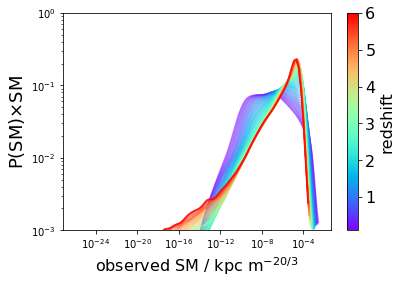

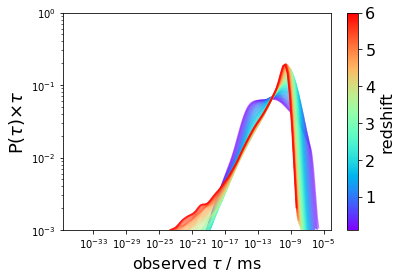

In [7]:
## check results
PlotLikelihoodEvolution( measure='SM', scenario={'Host':[model]} )
plt.ylim(1e-3,1)
plt.show()
PlotLikelihoodEvolution( measure='tau', scenario={'Host':[model]} )
plt.ylim(1e-3,1)
plt.show()


### Intervening Galaxies
Here, we translate the likelihood of SM from galaxies intervening LoS at $z_L$, $P(SM_{Inter}|z_L)$, to likelihood of scattering time for source at $z_s$, $P(\tau(SM_{Inter},z_s)|z_s)$.

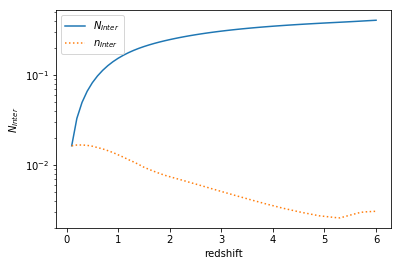

In [2]:
### plot likelihood for galaxies at redshift to intersect LoS, n_inter,
### as well as expectet number of galaxies in LoS to source, N_inter

model = 'Rodrigues18'

#n_inter = nInter( redshift_bins[-1], r=0.01/hubble_constant, n=0.02*hubble_constant**3 )
n_inter = nInter( redshift_bins[-1], model=model )
N_inter = np.cumsum( n_inter )

plt.plot( redshift_bins, N_inter, label=r"$N_{Inter}$" )
plt.plot( redshift_bins, n_inter, linestyle=':', label=r"$n_{Inter}$" )
plt.xlabel('redshift')
plt.ylabel(r"$N_{Inter}$")
plt.yscale( 'log')
plt.legend()

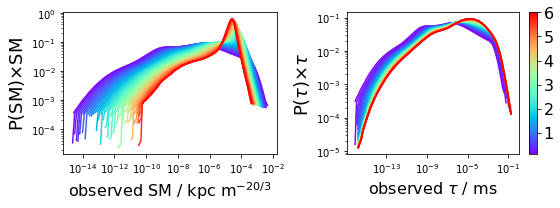

In [8]:
model = 'Rodrigues18'
fig, axs = plt.subplots( 1, 2, figsize=(8,3))

weights = nInter(redshift_bins[-1], model=model )  ## intersection probability for each redshift bin
redshift_L = redshift_bins - np.diff(redshift_range)/2  ## idealized possible intersection redshift, central redshift of bin

## for each source redshift
for i_s, (z_s, color) in enumerate( zip( redshift_bins, rainbow( np.linspace(0,1,len(redshift_bins)) ) ) ):
    Ps, xs = [], []
    ## for each possible redshift of intersection < z_s
    for i_L , (z_L, color_L) in enumerate( zip( redshift_L[:i_s+1], rainbow( np.linspace(0,1,len(redshift_bins)) ) ) ):
        ## read raw likelihood of SM from intervening galaxies at that redshift: P(SM_inter|z_L)
        P, SM = GetLikelihood_inter( redshift=redshift_bins[i_L], model=model, measure='SM')
        if i_s == len(redshift_bins) - 1:
            PlotLikelihood( x=SM, P=P, measure='SM', color=color_L, ax=axs[0] )
        ## calculate effective lense distance
        D_eff = Deff( z_s=z_s, z_L=z_L )
        ### translate x-axis
        x_tau = ScatteringTime( SM=SM, redshift=z_L, D_eff=D_eff )
        ## renormalize
        P *= np.diff(SM)/np.diff(x_tau)
        Ps.append(P)
        xs.append(x_tau)
    ## integrate results for all intervening redshifts, weighing and renormalizing with differential and cumulative intersection probability, respectively
    ### result is renormalized to 1, can be read out renormalized to N_inter with GetLikelihood_Inter( ..., N_inter=True )
    P, x = LikelihoodsAdd( Ps, xs, weights=weights[:i_s+1], renormalize=1)
    PlotLikelihood( x=x, P=P, measure='tau', color=color, ax=axs[1] )
    Write2h5( filename=likelihood_file_galaxy, datas=[P,x], 
             keys=[ KeyInter( redshift=z_s, model=model.split('/')[0], measure='tau', axis=axis) for axis in ['P','x'] ] 
            )

Colorbar(redshift_bins)
plt.tight_layout()
plt.show()


In [9]:
print(x.max())

0.20626871233978955


### validity of equations
Here we show, that we can always use equations in Marcquardt & Koay 2013 for the case $r_{\rm diff} > l_0$ 

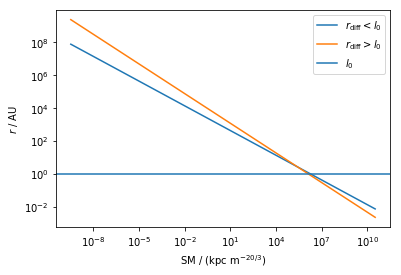

In [288]:
lambda_0 = 0.23 # m
#lambda_0 = 0.50 # m
l_0 = 1.496e11  # m  == 1 AU
kpc2m = 3.086e19 # m

SM_unit = 3.241e-8 # kpc m^-20/3 to 10^12 m^-17/3

## range of possible SM_eff 
SM_eff = 10.**np.linspace(10,30,100)/kpc2m ## kpc m^-20/3

#r_lo = ( 8e9 * lambda_0**-1 * (SM_unit*SM_eff)**-0.5 )**1.2 ## r < l_0, 
r_lo = 8e9 * lambda_0**-1 * (SM_unit*SM_eff)**-0.5  ## r < l_0, 
r_hi = 3.7e9 * lambda_0**-1.2 * (SM_unit*SM_eff)**-0.6      ## r > l_0

plt.loglog( SM_eff, r_lo/l_0, label=r"$r_{\rm diff} < l_0$" )
plt.plot( SM_eff, r_hi/l_0, label=r"$r_{\rm diff} > l_0$" )
plt.axhline(y=l_0/l_0, label=r"$l_0$")
plt.ylabel('$r$ / AU')
plt.xlabel('SM / (kpc m$^{-20/3}$)')
plt.legend()



For $\lambda = 0.23$ m, the $r_{diff}<l_0$ equations are valid, where the blue line is below $l_0 = 1$ AU.  The $r_{diff}>l_0$ equations are valid, where the orange line is above $l_0 = 1$ AU. Clearly, the latter is the case for all reasonable contributions to SM.